In [1]:
#Imports
import numpy as np
import scipy as sp
import healpy as hp
import histlite as hl
import csky as cy
import os
import gc
from glob import glob

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [38]:
#Overall TO DO:
#    * i3 --> numpy array:
#        * RAM and storage...L2 is a lot
#        * Use GRL
#    * Energy:
#        * Different binning for different energy ranges with different template smoothing per energy bin
#        * Injected spectrum
#    * Seasons: Combining different years/runs/detector configurations
#        * Time integration of acceptance? 
#        * Loading of MC arrays

In [11]:
class LiMaStats:
    """For conducting binned calculations using Li, Ma (1983) statistical methods. 
    For binned sky map of IceCube event data.
    
    
    """
    def __init__(self, data, sig, is_binned=False, savedir=None, name='LiMaBinnedTemplateAnalysis', 
                 template=None, is_smoothed_pdf=False, gamma=2.7, cutoff=None, 
                 nside=128, num_bands=100, min_dec_deg=-80, max_dec_deg=80):
        """LiMaStats constructor
        
        Args:
            data: Path to numpy array(s) (directory or single file) containing  dtype=[('run', '<i8'), 
                                                 ('event', '<i8'),
                                                 ('subevent', '<i8'),
                                                 ('ra', '<f8'),
                                                 ('dec', '<f8'),
                                                 ('azi', '<f8'),
                                                 ('zen', '<f8'),
                                                 ('time', '<f8'),
                                                 ('logE', '<f8'),
                                                 ##('angErr', '<f8')])
                                                 
                OR: Path to numpy array of binned data (in this case, set is_binned=True)
                                     
            sig: Path to numpy array(s) containing  dtype = [('run', int), 
                                                 ('event', int), 
                                                 ('subevent', int),
                                                 ('ra', float), 
                                                 ('dec', float),
                                                 ('true_ra', float), 
                                                 ('true_dec', float),
                                                 ('azi', float), 
                                                 ('zen', float), 
                                                 ('time', float),
                                                 ('logE', float), 
                                                 ('true_angErr', float), 
                                                 ('oneweight', float),     
                                                 ('true_energy', float)]
                                     
            is_binned: boolean, True if argument data is an array of binned_data, otherwise False (data will be binned)
            
            savedir: path to directory to save binned data and template pdf. Default: None (don't save)
            
            name: unique name to identify analysis (used in file names when saving)
            
            template: path to template object/array or None
                TO DO:
                    * Rescale template nside for differing energy ranges
                    
            is_smoothed_pdf: boolean, True if loaded template array (not from csky) is smoothed and pdf-ed, False if not. (Default: False)
                    
            ##smooth_sig: Sigma for smoothing of template (should be in radians)
                    
            gamma: spectral index for detector acceptance and injections. This should match the one used to create
                   the template if using one saved by csky. 
                    
            cutoff: minimum template value to be considered an On bin
                TO DO (???):
                    * Implementation without need for cutoff???

            nside: integer for healpy nside (Default: 128)
                TO DO: 
                    * Allow nside to differ for different energy ranges
            
            num_bands: integer, number of equal-width bands in sin(Dec) (Default: 100, will have width ~0.02 in sin(Dec))
            
            min_/max_dec_deg: min and max declination in degrees for likelihood calculations.
            
            
        """
        if template is None:
            raise NotImplementedError('Current implementation can only perform template analysis!')
        elif cutoff is None:
            raise NotImplementedError('Current implementation requires a cutoff to define on/off bins!')
        
        self.name = name
        self.savedir = savedir
        cy.utils.ensure_dir(savedir)
        
        self.gamma = gamma
        self.cutoff = cutoff
        self.nside = nside
        self.num_bands = num_bands
        
        self.sindec_bandedges = np.linspace(np.sin(np.radians(min_dec_deg)), np.sin(np.radians(max_dec_deg)), num_bands+1)
        self.band_width = 2. * np.sin(np.radians(85.)) / num_bands
        
        self.bin_thetas, self.bin_phis = hp.pix2ang(self.nside, np.arange(hp.nside2npix(self.nside))) 
        self.bin_ras = self.bin_phis
        self.bin_decs = np.pi/2.0 - self.bin_thetas
        
        self.bin_bands = np.digitize(np.sin(self.bin_decs), self.sindec_bandedges)
        
        if is_binned:
            self.binned_data = np.load(data)
            print(f'Load binned data <-- {data}')
            print(f'    Binned data loaded: Contains {len(self.binned_data)} bins with {np.sum(self.binned_data)} counts')
            if len(self.binned_data) != hp.nside2npix(self.nside):
                raise ValueError(f"Nside of loaded binned data is {hp.npix2nside(len(self.binned_data))}, but given nside is {self.nside}! You need to rebin your data.")
                
        else:
            self.load(data)
        
        self.sig_evs = np.load(sig)
        print(f'Load signal array <-- {sig}')
        smooth_sig = np.median(self.sig_evs['true_angErr'])
        print(f'    Median true angular error: {smooth_sig}')
        
        print(f'Load template <-- {template}')
        template = np.load(template, allow_pickle=True)
        
        
        if template.dtype == 'O':
            self.template = template.item()['template']
            if len(self.template) != hp.nside2npix(self.nside):
                print(f'Template nside does not match nside argument:')
                print(f'    Template: {hp.npix2nside(len(self.template))} --> Argument: {self.nside}')
                print('Adjusting resolution of template and making smoothed PDF... \n')
                
                self.template = hp.ud_grade(self.template, self.nside)
                self.create_template_pdf(smooth_sig)
                
            else:
                sigmas = np.radians(template.item()['sigmas_deg'])
                mindex = (np.abs(sigmas-np.degrees(smooth_sig))).argmin()
                self.template_pdf = template.item()['pdf_space_sig'][mindex]            
            
        else:
            self.template = template.copy()
            
            if len(self.template) != hp.nside2npix(self.nside):
                print(f'Template nside does not match nside argument:')
                print(f'    Template: {hp.npix2nside(len(self.template))} --> Argument: {self.nside}')
                print('Adjusting resolution of template and making smoothed PDF... \n')

                self.template = hp.ud_grade(self.template, self.nside)
                self.create_template_pdf(smooth_sig)
                
            elif is_smoothed_pdf:
                self.template_pdf = template.copy()
                
            else:
                self.create_template_pdf(smooth_sig)
            
        assert self.template.shape == self.template_pdf.shape, 'Template and template PDF shapes do not match...hmmm'
        assert len(self.template) == hp.nside2npix(self.nside), 'Number of bins in template does not match provided nside?!'
        assert len(self.template) == len(self.binned_data), 'Number of bins in template does not match number of bins in binned data!'

        
    def bin_data(self, data):#, truth=False, seed=None):
        """
        Convert event data into bin counts using healpy. 
        
        Args:
            data: data event array(s)
            
        #    truth: Whether to use true event locations (True), or scramble in right ascension (False)
        #
        #    seed: integer, Seed for numpy.random.default_rng() used to scramble events (Default: None, meaning unpredictable)
        """
        event_decs = data['dec']
        event_ras = data['ra']
        #if truth:
        #    event_ras = self.data['ra']
        #else:            
        #    rng_scramble = np.random.default_rng(seed=seed)                
        #    event_ras = 2.0 * np.pi * rng_scramble.random(size=len(self.data['ra']))
        
        print(f'Binning {len(event_ras)} events with nside={self.nside}...that is {hp.nside2npix(self.nside)} bins! Wow!', end=' ')
        
        event_pix_nums = hp.ang2pix(self.nside, np.pi/2.0 - event_decs, event_ras)
        
        print('--> Done.')

        return np.bincount(event_pix_nums)
    
    def load(self, path):
        """
        Loads data and bins it.
        
        Args:
            path: path to directory containing data files or path to a data file
            
        """
        assert (os.path.isdir(path) or os.path.isfile(path)), f"Expected path to directory or file, got: {path}"
        
        print(f'Loading and binning data from {path}')
        if os.path.isdir(path):
            files_like = path+'/*.npy'
            file_list = glob(files_like)
            binned_data = np.array([])
            for file in file_list:
                data = np.load(file)
                print(f'    {file} | ', end=' ')
                binned_data = np.append(binned_data, self.bin_data(data))
            
            self.binned_data = binned_data
        
        else:
            data = np.load(path)
            print(f'    {path} | ', end=' ')
            self.binned_data = self.bin_data(data)
            
        del data
        gc.collect()
        print('--> Done. \n')
        
        if self.savedir is not None:
            savefile = f'{self.savedir}/{self.name}.binned_data.npy'
            np.save(savefile, self.binned_data)
            print(f'Binned data saved to --> {savefile}')
            

        return
        
    
    def create_bg_acc_spline(self, skw={}):
        """
        Create detector acceptance spline (*background*, sinDec-dependent) for weighted product of likelihoods across declinations.
        
        Pieces taken from csky.
        
        TO DO: Is this right?
        
        Args:          
            skw: histlite.Hist.spline_fit kwargs
        
        Returns: histlite spline object
        
        """
                
        h_counts = hl.hist(np.sin(self.bin_decs), weights=self.binned_data)
        h = h_counts.normalize(density=True) / (2*np.pi)
        hrange = h.range[0]
        
        skw.setdefault('s', 0)
        skw.setdefault('k', 2)
        skw.setdefault('log', True)
        s_hl = h.spline_fit(**skw)
        
        self.bg_acc_spline = s_hl.spline
        
        return self.bg_acc_spline
    
    def create_signal_acc_spline(self, skw={}):
        """
        Create detector acceptance spline (*signal*, sinDec-dependent) for weighted product of likelihoods across declinations.
        
        Pieces taken from csky.
        
        TO DO: Is this right? Spline could use some work.
        
        Args:
            skw: histlite.Hist.spline_fit kwargs (Unused.)
        
        Returns: scipy spline object
        
        """
        
        '''
        xs = np.r_[self.bin_decs[0], self.bin_decs, self.bin_decs[-1]]
        ws = np.r_[(self.template_pdf)[0], self.template_pdf, (self.template_pdf)[-1]]
        h_counts = hl.hist(xs, weights=ws, bins=30)   #Evaluate accuracy of this spline especially at poles
        h = h_counts.normalize(density=True) / (2*np.pi)
        hrange = h.range[0]
        
        skw.setdefault('s', 0)
        skw.setdefault('k', 2)
        skw.setdefault('log', True)
        s_hl = h.spline_fit(**skw)
        
        self.signal_acc_spline = s_hl.spline
        '''
        
        print('Using csky to obtain acceptance spline...')
        a = cy.utils.Arrays(init=self.sig_evs, convert=True)
        spl = cy.pdf.SinDecAccParameterization(a).s
        print('--> Done.')
        
        self.signal_acc_spline = spl

        return self.signal_acc_spline
    
    def get_acc_from_spline(self, sindec, acc='signal'):
        """
        Used spline to get acceptance at a give sin(Dec).
        
        Args:
            sindec: Sine of declination(s)
            
            acc: One of "signal" or "bg" for which acceptance spline to use. (Default: 'template')
            
        Returns: acceptance(s) for provided sin(Dec).
        
        """
        
        if acc == 'signal':
            try:
                out = np.exp(self.signal_acc_spline.ev(self.gamma, sindec))
            except AttributeError:
                print('Signal acceptance spline not yet created. Creating now... \n')
                self.create_signal_acc_spline()
                out = np.exp(self.signal_acc_spline.ev(self.gamma, sindec))
                
            return out
                
        elif acc == 'bg':
            try:
                out = np.exp(self.bg_acc_spline(sindec))
            except AttributeError:
                print('Background acceptance spline not yet created. Creating now... \n')
                self.create_bg_acc_spline()
                out = np.exp(self.bg_acc_spline(sindec))
                
            return out
        
        else:
            raise NotImplementedError('Argument spline must be one of ["signal", "bg"].')
            
    def create_template_pdf(self, smooth_sig):
        """
        Applies detector acceptance to spline and smooths.
        
        Args:
            smooth_sig: Sigma (in radians) for gaussian smoothing using healpy.smoothing(x, sigma=smooth_sig)

        """
        
        print("Applying detector acceptance to template...")
        #Make acceptance spline
        self.create_signal_acc_spline()
        #Apply spline
        template_pdf = self.template * np.exp(self.signal_acc_spline.ev(self.gamma,np.sin(self.bin_decs))) 
        #Normalize
        template_pdf = template_pdf / (np.sum(template_pdf))
        mask = (self.template > 0) & (template_pdf <= 0)
        template_pdf[mask] = hp.UNSEEN

        
        print(f"Applying angular smoothing to template with sigma = {smooth_sig} radians")
        #Smooth
        #template_pdf = self.template.copy()
        template_pdf = hp.smoothing(template_pdf, sigma=smooth_sig)
        #Reset nonsensical values 
        template_pdf[mask] = 0
        template_pdf[template_pdf < 1e-12] = 1e-12
        dec_mask = (self.bin_decs<np.radians(85)) & (self.bin_decs>np.radians(-85))
        #Re-normalize
        template_pdf = template_pdf / ( np.sum(template_pdf[dec_mask]) * hp.nside2pixarea(self.nside) )

        self.template_pdf = template_pdf
        print('--> Done. \n')
        
        if self.savedir is not None:
            savefile = f'{self.savedir}/{self.name}.sigma_{round(smooth_sig,2)}.template_pdf.npy'
            np.save(savefile, self.template_pdf)
            print(f'Template PDF saved to --> {savefile}')
        
        return

    def template_counter(self, sindec):
        """
        Gets on and off counts and alpha by performing (weighted) sum of bin counts in a given sindec band. 
        On bins are defined as having template weights greater than or equal to the cutoff.
        OLD: Alpha is the ratio of number of on bins to off bins, since each bin has the same area.
        NEW: Alpha is the ratio of the sum of on template values to off template values.
        
        Args:
            sindec: Sine of declination (radians) for band of bins
            
        *Note*: Data may not have been re-binned after injections! 
            
        Returns: alpha, number of On counts, number of Off counts
        """
        bin_band_idx = self.bin_bands
        bin_idx = np.digitize(sindec, self.sindec_bandedges)
        
        mask_sindec = (bin_band_idx == bin_idx)
            
        template_dec = self.template_pdf[mask_sindec]
        binned_data_dec = self.counts[mask_sindec]
        
        assert template_dec.shape == binned_data_dec.shape
        
        mask_cutoff = (template_dec > self.cutoff)
        
        N_on = np.sum(np.multiply(template_dec[mask_cutoff] , binned_data_dec[mask_cutoff]))
        N_off = np.sum(binned_data_dec[~mask_cutoff])                                  #I think this should be weighted too...? Or normalized?
        #alpha = np.sum(mask_cutoff) / np.sum(~mask_cutoff)                            #Unweighted ratio of # of on to off bins
        #alpha = np.sum(template_dec[mask_cutoff]) / np.sum(template_dec[~mask_cutoff]) #Weighted sum, i.e. ratio of template value sums
        alpha = np.sum(template_dec[mask_cutoff]) / np.sum(~mask_cutoff)
        
        return alpha, N_on, N_off
    
    def likelihood_ratio(self, sindec):
        """
        Calculation of likelihood ratio for the given declination.
        
        Args:
            sindec: Sine of declination for band of bins
            
        *Note*: Data may not have been re-binned after injections! 
            
        Returns: likelihood ratio (float)
        
        """
        
        print(f'Getting likelihood ratio for bins with sin(Dec)={sindec} +/- {self.band_width}:')
        
        alpha, N_on, N_off = self.template_counter(sindec)

        print(f'    alpha = {alpha}')
        print(f'    N_on  = {N_on}')
        print(f'    N_off = {N_off}')
        
        if alpha == 0.0:
            lhr = 1.0
        elif alpha == np.inf:
            lhr = 0.0
        else:
            first_term = ( (alpha / (1+alpha)) * ((N_on + N_off) / N_on) )**N_on
            second_term = ( (1 / (1+alpha)) * ((N_on + N_off) / N_off) )**N_off

            lhr = first_term * second_term

        print(f' * Likelihood Ratio for DEC={np.degrees(np.arcsin(sindec))} deg: {lhr}')
        print(' ')

        return lhr
        
    def allsky_likelihood(self, acc='signal'):
        """
        Get likelihood ratios for every declination and combine.
        
        Args:
            acc: One of "signal" or "bg" for which acceptance spline to use. (Default: 'signal')
        
        *Note*: Data may not have been re-binned after injections! 
        
        Returns: the all-sky likelihood ratio (lambda in Li, Ma (1983)), and dictionary of {sindec: lhr} for sin(Dec) bands
            
        """
        sindec_list = self.sindec_bandedges[:-1] + self.band_width/2.0
        
        sindec_lhrs = {}
        sindec_accs = {}
        
        if acc not in ['signal', 'bg']:
            raise ValueError('Argument spline must be one of ["signal", "bg"].')
            
        print(f'==== Getting all-sky likelihood ratio for nside={self.nside} with {acc} acceptances ====')
        for sindec in sindec_list:
            sindec_lhrs[sindec] = self.likelihood_ratio(sindec)
            sindec_accs[sindec] = self.get_acc_from_spline(sindec, acc=acc)
        
        lhrs = np.array(list(sindec_lhrs.values()))
        accs = np.array(list(sindec_accs.values()))
        #allsky_lhr = accs_prod * lhrs_prod
        allsky_lhr = np.exp(np.sum(accs * np.log(lhrs)))             #Weighted sum of log(LHR)s 
        
        sindec_lhrs = {'sindec': sindec_lhrs}
        sindec_accs = {'sindec': sindec_accs}
        
        print('--> Done.')
        return allsky_lhr, sindec_lhrs, sindec_accs
    
    def get_one_lhr(self, n_sig=0, acc='signal', truth=False, seed=None):
        """
        Obtains a single all-sky likelihood ratio.
        
        Args:
            n_sig: number of (signal) events to inject (Default: 0). Only used if truth=False
            
            acc: One of "signal" or "bg" for which acceptance spline to use. (Default: 'signal')
        
            truth: Whether to use true event locations (True), or scramble in right ascension (False)
        
            seed: integer, Seed for numpy.random.default_rng() used to scramble events and pick injection locations
                  (Default: None, meaning unpredictable)
            
        Returns: dictionary containing all-sky LHR, sinDec LHRs, and sinDec acceptances
        
        """
        if truth:
            self.counts = self.binned_data.copy()
            allsky_lhr, sindec_lhrs, sindec_accs = self.allsky_likelihood(acc=acc)
        else:
            self.counts = self.scrambler(seed=seed)
            if n_sig == 0:
                allsky_lhr, sindec_lhrs, sindec_accs = self.allsky_likelihood(acc=acc)
            else:
                self.template_injector(n_sig=n_sig, seed=seed)
                allsky_lhr, sindec_lhrs, sindec_accs = self.allsky_likelihood(acc=acc)
                
        result = {'allsky_lhr': allsky_lhr, 
                  'sindec_lhrs': sindec_lhrs, 
                  'sindec_accs': sindec_accs}
        
        return result
    
    def get_many_lhrs(self, num, n_sig=0, acc='signal', seed=None):
        """
        Obtains multiple likelihood ratios
        
        Args:
            num: integer, number of lhrs to compute
            
            n_sig: number of (signal) events to inject (Default: 0)
                        
            acc: One of "signal" or "bg" for which acceptance spline to use. (Default: 'signal')
            
            seed: integer, seed used to create multiple new seeds for scrambles (Default: None, unpredictable)
            
        Returns: dictionary with {'n_sig': n_sig, 'seed': {new_seed: allsky_lhr} }
        
        """
            
        lhrs = {}
        
        num = int(num)
        if num < 1:
            raise ValueError(f'num must be a positive integer, got: {num}')
        elif num == 1:
            lhrs[seed] = self.get_one_lhr(n_sig=n_sig, seed=seed, acc=acc)['allsky_lhr']
        else:
            rng_seed = np.random.default_rng(seed)
            for i in range(1, num+1):
                new_seed = rng_seed.integers(int(1e9))

                lhrs[new_seed] = self.get_one_lhr(n_sig=n_sig, seed=new_seed, acc=acc)['allsky_lhr']
                    
        lhrs = {'n_sig': n_sig, 'seed': lhrs}
        return lhrs        
        
    def get_TS_from_lhr(self, lhr):
        """
        Simple conversion to TS from a give likelihood ratio.
        
        Args:
            lhr: float or array of floats, likelihood ratio to be converted to TS
        
        Returns: float or array of floats, TS
            
        """
        return -2.0 * np.log(lhr)
    
    def fit_TS_chi2(self, tss):
        """
        Fit distribution of TSs > 0 with a chi-squared funtion.
        
        Args:
            tss: array of TSs
        
        Returns: Chi2 degrees of freedom, location, scale parameters
        
        """
        self.eta = np.mean(tss>0)
        self.df, self.loc, self.scale = sp.stats.chi2.fit(tss[tss>0], 1)     # 1 indicates starting guess for chi2 degrees of freedom
        self.chi2_fit = sp.stats.chi2(self.df, self.loc, self.scale)
        
        print('Chi2 distribution fit to TS > 0 with:')
        print(f'    DoF: {self.df}')
        print(f'    loc: {self.loc}')
        print(f'    scale: {self.scale}')
        print(f'    eta: {self.eta}')
        
        return 
    
    def TS_to_p(self, ts, bg=None, use='fit', dof=1):
        """
        Converts given TS to p-value using chosen method.
        
        Args:
            ts: float or array of floats, TS to convert to p-value
            
            bg: None or array, background TSs (Default: None)
            
            use: string, which method/distribution to use.
                 One of 'fit', 'chi2_dof', or 'hist'. If 'fit' and argument bg is not None, will fit a Chi2 distribution to\
                 the provided bg distribution. If 'chi2_dof', will use a Chi2 with provided dof and loc=0, scale=1. If \
                 'hist', will use the bg TSs themselves. (Default: 'fit')
                 
            dof: Number of degrees of freedom to use if use='chi2_ndof'
            
        Returns: p-value(s)
                 
        """
        if use not in ['fit', 'chi2_dof', 'hist']:
            raise ValueError(f'Argument use must be one of "fit", "chi2_dof", or "hist", got "{use}"')
            
        if (use == 'chi2_ndof') or (bg is None):
            #TS --> p using generic Chi2 function
            #Necessary if no BG distribution is provided
            
            print(f'Calculating p-value(s) using a Chi2 Distribution with {dof} degrees of freedom...')
            p = sp.stats.chi2.sf(ts, df=dof)
            print(f'    p = {p}')
            
        elif use == 'fit':
            #TS --> p using Chi2 fit
            #Requires BG dist to be provided
            
            print(f'Calculating p-value(s) using a Chi2 Distribution fit to provided background...')
            self.fit_TS_chi2(bg)
            p = self.chi2_fit.sf(ts)
            print(f'    p = {p}')
            
        elif use == 'hist':
            #TS --> p using distribution directly
            #Requires BG dist to be provided
            
            print(f'Calculating p-value(s) using background TSs distribution directly...')
            p = np.array([np.mean(bg >= t) for t in ts])
            print(f'    p = {p}')
            
        return p
    
    def create_bin_count_spline(self):
        """
        TEST THIS
        """
        bs = [-np.pi/2] + list(np.unique(self.bin_decs)[:-1] + .5*np.diff(np.unique(self.bin_decs))) + [np.pi/2]
        h = hl.hist((self.binned_data, np.sin(self.bin_decs)), bins = (np.arange(0,np.max(self.binned_data)+1), np.sin(bs)))

        skw = {}
        skw.setdefault('s', 0)
        skw.setdefault('kx', 2)
        skw.setdefault('ky', 2)
        s_hl = h.spline_fit(**skw)
        
        self.bin_count_spline = s_hl.spline
        
        return
    
    def scrambler(self, seed=None):
        """
        Gets a map of "scrambled" counts by sampling from self.bin_count_spline with given sindec
        
        Args:       
            seed: integer, Seed for numpy.random.default_rng() used to scramble events and pick injection locations
                  (Default: None, meaning unpredictable)
        
        """
        if not hasattr(self, 'bin_count_spline'):
            self.create_bin_count_spline()
        
        unique_decs = np.unique(self.bin_decs)
        
        rng_scramble = np.random.default_rng(seed=seed)
        counts = np.zeros_like(self.binned_data)
        for dec in unique_decs:
            mask = (self.bin_decs == dec)
            crange = np.arange(0, np.max(self.binned_data[mask])+1, 1)
            weights = np.clip(self.bin_count_spline.ev(crange, dec), a_min=1e-12, a_max=None)
            counts[mask] = rng_scramble.choice(crange, size=np.sum(mask), p=weights/np.sum(weights))
            
        return counts
            
    
    def template_injector(self, n_sig, seed=None):
        """
        Injects events based on template probabilities.
        This function adds injected events directly to the LiMaStats.binned_data object.
        
        Args:
            n_sig: number of events to inject (with poisson fluctuations)
            
            seed: integer, Seed for numpy.random.default_rng() used to pick injection locations (Default: None, meaning unpredictable)
            
        """
        #NOTE: energy not yet implemented. Gamma is unused here!
                           
        rng_inj = np.random.default_rng(seed=seed)
        poisson_n_sig = rng_inj.poisson(lam=n_sig)
        self.inj_bins = rng_inj.choice(hp.nside2npix(self.nside), size=poisson_n_sig, p=self.template_pdf/np.sum(self.template_pdf))

        print(f'Injecting {n_sig} events according to template probabilities with poisson fluctuation...')

        for i in self.inj_bins:
            self.counts[i] += 1
                
        return          
        

In [13]:
#data_arr = np.load('./test/IC86_2016_exp.npy', allow_pickle=True)
#sig_arr = np.load('./test/IC86_2016_MC.npy', allow_pickle=True)
#template_arr = np.load('./templates/Fermi-LAT_pi0_map.npy', allow_pickle=True)

In [3]:
data_path = './test/IC86_2016_exp.npy'
sig_path = './test/IC86_2016_MC.npy'
template_path = './templates/Fermi-LAT_pi0_map.npy'

In [12]:
lima_bean = LiMaStats(data_path, sig_path, is_binned=False, savedir='./test', name='LiMaBinnedTemplateAnalysisTEST', 
                 template=template_path, is_smoothed_pdf=False, gamma=2.7, cutoff=10**(-0.8), 
                 nside=32, num_bands=50, min_dec_deg=-80, max_dec_deg=80)

Loading and binning data from ./test/IC86_2016_exp.npy
    ./test/IC86_2016_exp.npy |  Binning 126263 events with nside=32...that is 12288 bins! Wow! --> Done.
--> Done. 

Binned data saved to --> ./test/LiMaBinnedTemplateAnalysisTEST.binned_data.npy
Load signal array <-- ./test/IC86_2016_MC.npy
Load template <-- ./templates/Fermi-LAT_pi0_map.npy
Template nside does not match nside argument:
    Template: 128 --> Argument: 32
Adjusting resolution of template and making smoothed PDF... 

Applying detector acceptance to template...
Using csky to obtain acceptance spline...
  * gamma = 4.0000 ...
--> Done.
Applying angular smoothing to template with sigma = 0.008726646259971648 radians
--> Done. 

Template PDF saved to --> ./test/LiMaBinnedTemplateAnalysisTEST.sigma_0.01.template_pdf.npy


In [13]:
result = lima_bean.get_one_lhr(n_sig=0, acc='signal', truth=False, seed=12)

==== Getting all-sky likelihood ratio for nside=32 with signal acceptances ====
Getting likelihood ratio for bins with sin(Dec)=-0.9648838590503731 +/- 0.039847787923669824:
    alpha = 0.0
    N_on  = 0.0
    N_off = 1507
 * Likelihood Ratio for DEC=-74.77104232695244 deg: 1.0
 
Getting likelihood ratio for bins with sin(Dec)=-0.9254915489298848 +/- 0.039847787923669824:
    alpha = 0.0
    N_on  = 0.0
    N_off = 1474
 * Likelihood Ratio for DEC=-67.7425934581095 deg: 1.0
 
Getting likelihood ratio for bins with sin(Dec)=-0.8860992388093965 +/- 0.039847787923669824:
    alpha = 0.0
    N_on  = 0.0
    N_off = 1979
 * Likelihood Ratio for DEC=-62.387099007424474 deg: 1.0
 
Getting likelihood ratio for bins with sin(Dec)=-0.8467069286889082 +/- 0.039847787923669824:
    alpha = 0.0
    N_on  = 0.0
    N_off = 1759
 * Likelihood Ratio for DEC=-57.85528300037718 deg: 1.0
 
Getting likelihood ratio for bins with sin(Dec)=-0.8073146185684198 +/- 0.039847787923669824:
    alpha = 0.0
    N_

In [14]:
result

{'allsky_lhr': 1.6326843901423654e-110,
 'sindec_lhrs': {'sindec': {-0.9648838590503731: 1.0,
   -0.9254915489298848: 1.0,
   -0.8860992388093965: 1.0,
   -0.8467069286889082: 1.0,
   -0.8073146185684198: 1.0,
   -0.7679223084479315: 1.0,
   -0.7285299983274431: 1.0,
   -0.6891376882069549: 1.0,
   -0.6497453780864666: 1.0,
   -0.6103530679659782: 1.0,
   -0.5709607578454898: 1.0,
   -0.5315684477250016: 1.0,
   -0.4921761376045133: 1.0,
   -0.4527838274840249: 1.0,
   -0.41339151736353663: 1.0,
   -0.37399920724304825: 1.0,
   -0.33460689712256: 1.0,
   -0.2952145870020717: 1.0,
   -0.2558222768815833: 1.0,
   -0.21642996676109505: 0.9000151439964034,
   -0.17703765664060667: 0.9934882400388376,
   -0.1376453465201184: 0.9996531579865194,
   -0.09825303639963001: 0.9982820616018867,
   -0.05886072627914174: 0.5312166868781518,
   -0.01946841615865347: 0.07135593393267774,
   0.019923893961834912: 0.9738983954742779,
   0.0593162040823233: 0.8233122190087341,
   0.09870851420281157: 0.

In [23]:
sp.integrate.quad(lambda x: np.exp(lima_bean.signal_acc_spline.ev(2.7, x)), -1, 1)

(0.10073833278384592, 1.1341015015917983e-08)

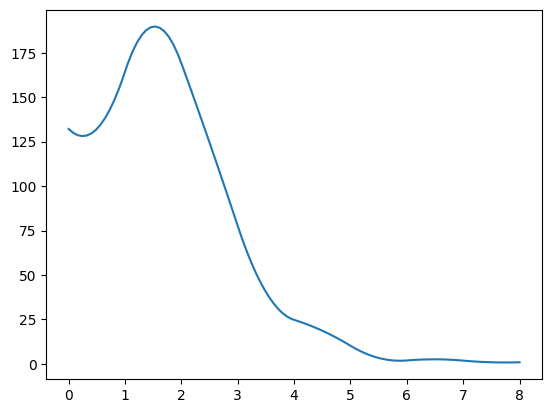

In [43]:
plt.plot(xs, lima_bean.bin_count_spline.ev(xs, .05))

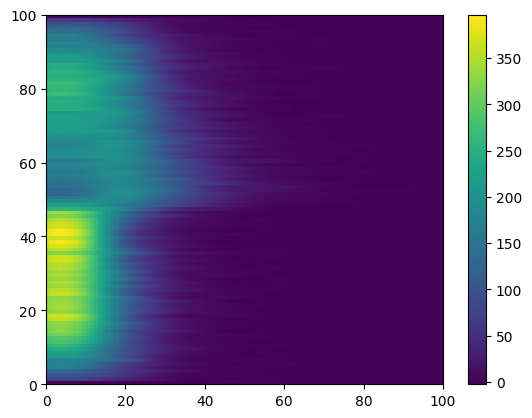

In [38]:
xs = np.linspace(0,8,100)
ys = np.linspace(-1,1,100)
X, Y = np.meshgrid(xs, ys)
plt.pcolormesh(lima_bean.bin_count_spline.ev(X, Y))
plt.colorbar()
plt.show()

In [9]:
bs = ([-np.pi/2] + list(np.unique(lima_bean.bin_decs)[:-1] + .5*np.diff(np.unique(lima_bean.bin_decs))) + [np.pi/2])

In [10]:
h = hl.hist((lima_bean.binned_data, np.sin(lima_bean.bin_decs)), bins = (np.arange(0,np.max(lima_bean.binned_data)+1),np.sin(bs)))

skw = {}
skw.setdefault('s', 0)
skw.setdefault('kx', 2)
skw.setdefault('ky', 2)
s_hl = h.spline_fit(**skw)
s = s_hl.spline

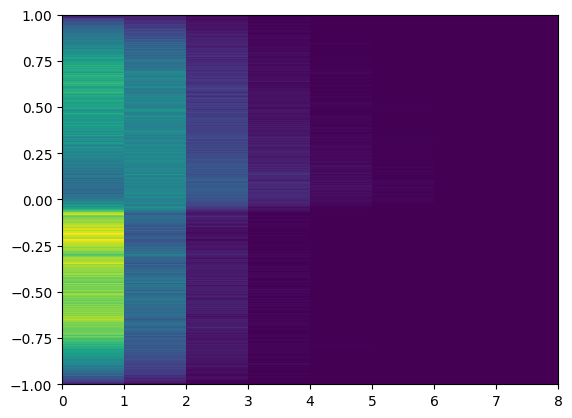

In [11]:
fig, ax = plt.subplots()
hl.plot2d(ax, h)

In [3]:
pixarea = hp.nside2pixarea(128)
bin_thetas, bin_phis = hp.pix2ang(128, np.arange(hp.nside2npix(128))) 
bin_ras = bin_phis
decs = np.pi/2.0 - bin_thetas

In [6]:
spline = lima_bean.create_signal_acc_spline()
decs = lima_bean.bin_decs

In [4]:
a = cy.utils.Arrays(init=sig_arr, convert=True)
p = cy.pdf.SinDecAccParameterization(a)
q = p.s.ev

  * gamma = 4.0000 ...


In [6]:
csky_pdf = template_arr.item()['pdf_space_sig'][1]

In [8]:
print(csky_pdf)

[0.15353575 0.15463257 0.1380517  ... 0.00044565 0.00044694 0.00047274]


In [30]:
x = template_arr
x = x * np.exp(q(2.7,np.sin(decs))) 
x = x / (np.sum(x))
mask = (template_arr > 0) & (x <= 0)
x[mask] = hp.UNSEEN
x = hp.smoothing(x, sigma=np.radians(.5))
x[mask] = 0
x[x < 1e-12] = 1e-12
dec_mask = (decs<np.radians(85)) & (decs>np.radians(-85))
x = x / ( np.sum(x[dec_mask]) * pixarea )

In [7]:
x.shape

(49152,)

<Figure size 640x480 with 0 Axes>

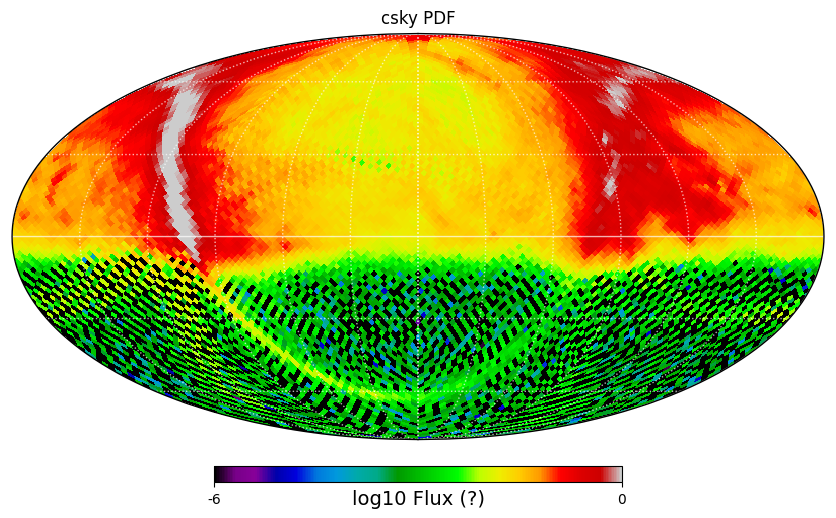

In [5]:
plt.figure(facecolor='w')
#x = template_arr.item()['template']
#x1 = hp.smoothing(x, sigma=np.radians(.5)) * np.exp(q(2.7,np.sin(decs)))  
#x1 /= np.sum(x1)*pixarea
#x3 = template_arr.item()['pdf_space_sig'][1]

x = lima_bean.template_pdf

hp.mollview(np.log10(x), unit='log10 Flux (?)', rot=(180,0,0), cmap='nipy_spectral', title='csky PDF', min=-6, max=0) 
hp.graticule(30, color='w', alpha=0.7)
plt.show()

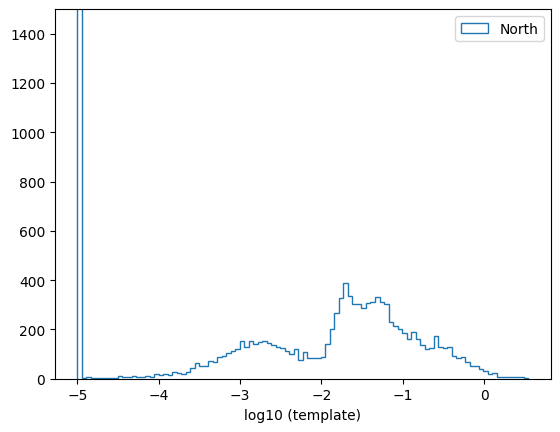

In [9]:
plt.figure(facecolor='w')
plt.hist(np.log10(np.clip(x, a_min=1e-5, a_max=None)), bins=100, histtype='step', label='North')
#plt.vlines(-2.2, 0, 3000, color='k')
#plt.vlines(-.75, 0, 3000, color='k')
#plt.semilogy()
plt.xlabel('log10 (template)')
plt.legend()
plt.ylim(top=1500)
plt.show()

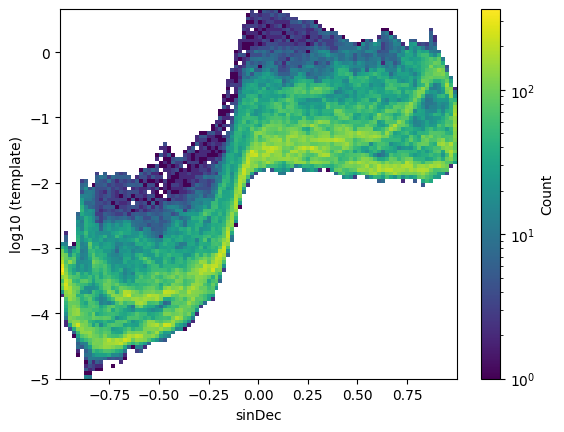

In [42]:
plt.figure(facecolor='w')
plt.hist2d(np.sin(decs), np.log10(np.clip(x, a_min=1e-5, a_max=None)), bins=100, norm=LogNorm())
plt.xlabel('sinDec')
plt.ylabel('log10 (template)')
plt.colorbar(label='Count')
plt.show()

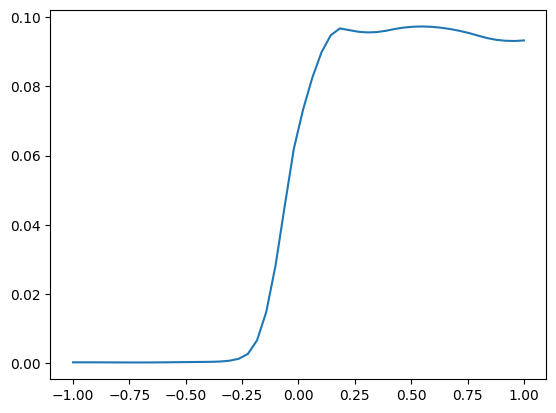

In [26]:
fig = plt.figure()
xs = np.linspace(-1,1,50)
plt.plot(xs, np.exp(p.s.ev(2.7,xs)))
plt.show()

{'colormesh': <matplotlib.collections.QuadMesh at 0x7f6c09dc3ad0>,
 'colorbar': <matplotlib.colorbar.Colorbar at 0x7f6c09ec1d90>}

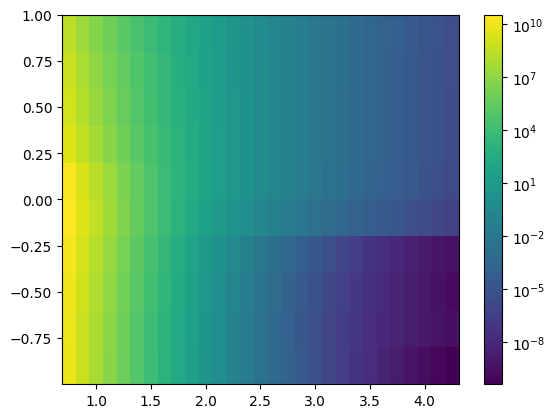

In [21]:
fig, ax = plt.subplots()

hl.plot2d(ax, p.h, cbar=True, log=True)

In [2]:
a = np.load('data/level2/exp/Level2_01012020_exp.npy')

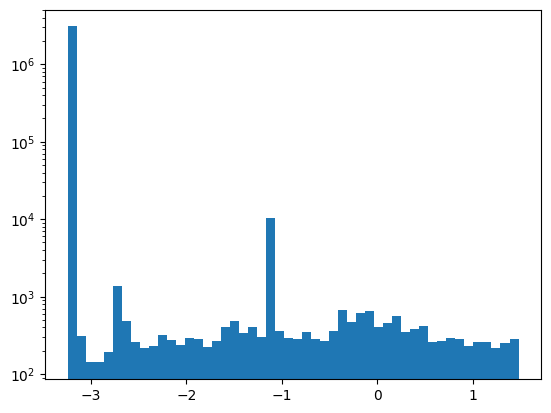

In [13]:
angErr = a['angErr']
plt.hist(np.log10(np.degrees(np.clip(angErr, a_min=1e-5, a_max=None))), bins=50)
plt.semilogy()
plt.show()

In [14]:
a.shape

(3112063,)

In [15]:
a

array([(133575,     4864, 0, 3.22138377, -0.48603716, 0.09457757, 1.08297815, 58849.00036607, 3.90547542, 2.48671382e-316),
       (133575,     4887, 0, 4.33465193,  0.65305468, 5.26605148, 2.22320356, 58849.00036615, 2.80967984, 1.52973828e-308),
       (133575,     4928, 0, 5.52539254, -0.84797305, 4.07263382, 0.72415446, 58849.00036632, 3.78225842, 3.60739284e-313),
       ...,
       (133578, 84538514, 0, 2.04542437,  1.02565203, 1.35097114, 2.59550676, 58850.01082997, 2.85765032, 7.29112571e-304),
       (133578, 84538548, 0, 5.77999132,  0.44290933, 3.90286826, 2.01538085, 58850.01083009, 2.81958413, 0.00000000e+000),
       (133578, 84538549, 0, 4.04073056,  0.52984329, 5.6426174 , 2.09951094, 58850.0108301 , 3.37948304, 4.78414041e-314)],
      dtype=[('run', '<i8'), ('event', '<i8'), ('subevent', '<i8'), ('ra', '<f8'), ('dec', '<f8'), ('azi', '<f8'), ('zen', '<f8'), ('time', '<f8'), ('logE', '<f8'), ('angErr', '<f8')])